In [40]:
import warnings

import numpy as np
import pandas as pd
import sklearn.datasets as datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# データの読み込み
# 例としてscikit-learnで提供されているカリフォルニアの住宅価格データを用いる
data = datasets.fetch_california_housing()

X = data["data"]
y = data["target"]

# 見やすいようにDataFrameにする
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                  columns=data.feature_names+["price"])
display(df)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


比較用にすべての特徴量をそのまま使用したときのスコアを計算する．  
回帰問題のため，スコアにはRMSEを用いる．  

In [17]:
# データ全体を用いた場合
# 訓練用データとテストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=6174)

# 訓練商データを更に訓練用と検証用に分ける
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

# 線形回帰ではスケーリングが必要
# GBDTでは大小関係のみ必要なため特に影響はない
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X, test_X = sc.transform(val_X), sc.transform(test_X)

linear = Ridge()
lgbmodel = lgb.LGBMRegressor(n_jobs=12, random_state=6174)

linear.fit(train_X, train_y)
lgbmodel.fit(train_X, train_y, eval_set=(val_X, val_y), verbose=-1)

linear_val_pred = linear.predict(val_X)
linear_test_pred = linear.predict(test_X)
linear_val_rmse = mse(val_y, linear_val_pred, squared=False)
linear_test_rmse = mse(test_y, linear_test_pred, squared=False)

lgb_val_pred = lgbmodel.predict(val_X)
lgb_test_pred = lgbmodel.predict(test_X)
lgb_val_rmse = mse(val_y, lgb_val_pred, squared=False)
lgb_test_rmse = mse(test_y, lgb_test_pred, squared=False)

print(f"Linear Model(Ridge) val score: {linear_val_rmse:.4f} test_score: {linear_test_rmse:.4f}")
print(f"LGB Model val score: {lgb_val_rmse:.4f} test score: {lgb_test_rmse:.4f}")

Linear Model(Ridge) val score: 0.7795 test_score: 0.7331
LGB Model val score: 0.4805 test score: 0.4690


## フィルター法  
データを統計的に分析したときの結果を用いて使用する特徴量を選択する手法．  
ここでは最も簡単な相関係数を用いて選択する．仮定として目的変数と強い相関がある変数は特徴量として予測に大きく寄与するものと考えている．  

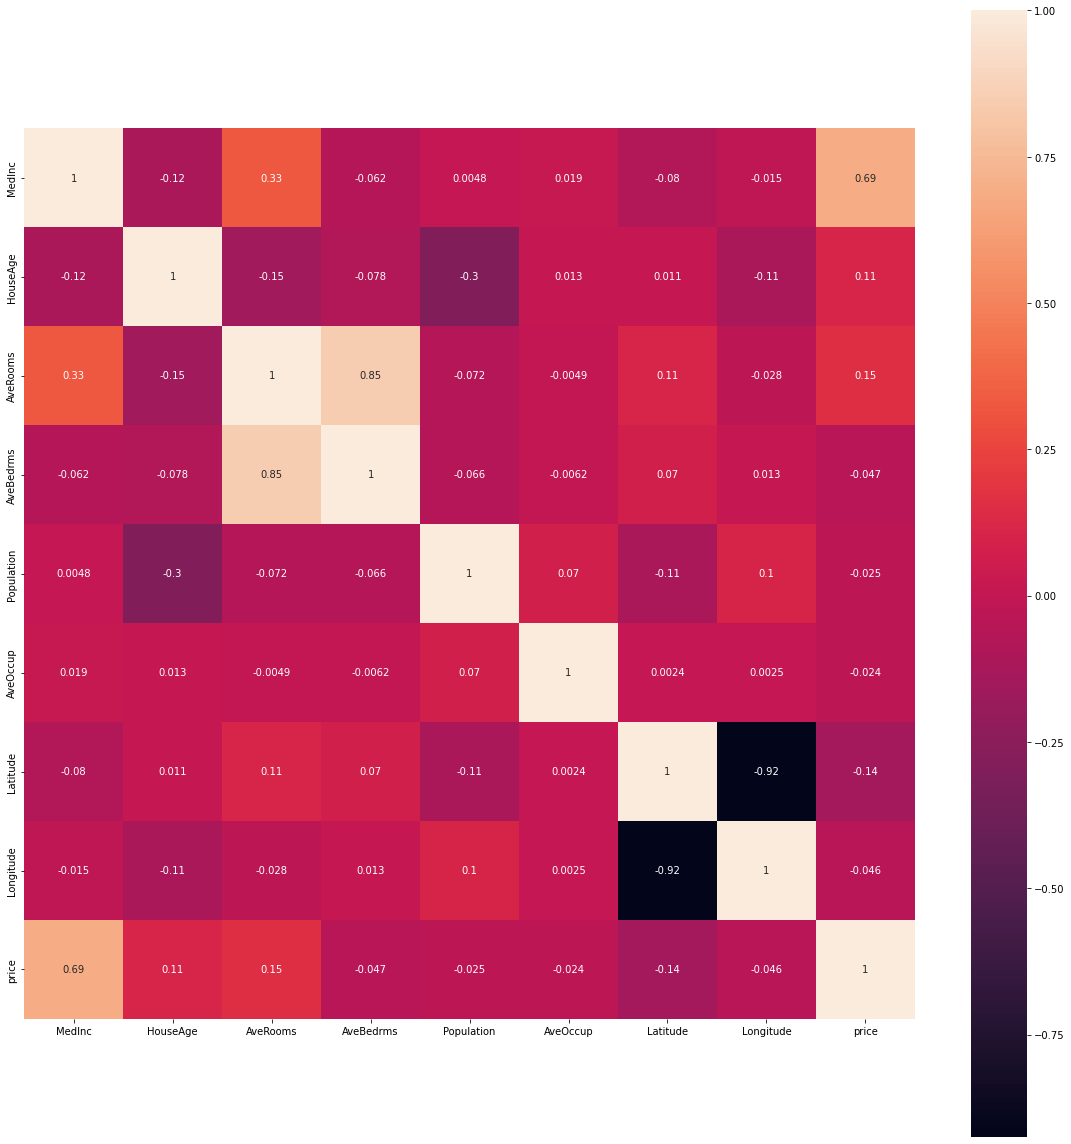

In [5]:
# 相関係数の算出，プロット
corr = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, square=True)
plt.tight_layout()

plt.show()

目的変数である"price"と相関があるものとして"MedInc"が0.69と相関があることがわかります．その他の変数は非常に小さい相関になっているのがわかります．

試しに"MedInc"と"price"をプロットしてみることで，相関関係を可視化してみます．  

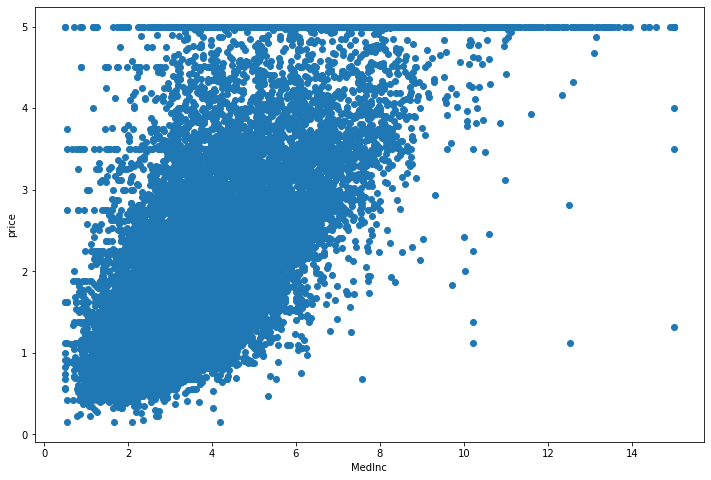

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(df["MedInc"].values, df["price"].values)
plt.xlabel("MedInc")
plt.ylabel("price")

plt.show()

グラフから正の相関があることがわかります（最大値付近でx軸方向に一直線になっていることが気になりますが，話がそれるのでここでは気にしません．データ分析等では気にしたほうが良いと思います）．  

精度としてあまり良くならなそうですが，"MedInc"のみを説明変数として"price"の値を予測してみます．モデルとして線形回帰とlightgbmを用いてみます．  

In [19]:
# 訓練用データとテストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X[:, 0], y, test_size=0.1, random_state=6174)

# 訓練商データを更に訓練用と検証用に分ける
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

train_X, val_X, test_X = train_X.reshape(-1, 1), val_X.reshape(-1, 1), test_X.reshape(-1, 1)

# 線形回帰ではスケーリングが必要
# GBDTでは大小関係のみ必要なため特に影響はない
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X, test_X = sc.transform(val_X), sc.transform(test_X)

linear = Ridge()
lgbmodel = lgb.LGBMRegressor(n_jobs=12, random_state=6174)

linear.fit(train_X, train_y)
lgbmodel.fit(train_X, train_y, eval_set=(val_X, val_y), verbose=-1)

linear_val_pred = linear.predict(val_X)
linear_test_pred = linear.predict(test_X)
linear_val_rmse = mse(val_y, linear_val_pred, squared=False)
linear_test_rmse = mse(test_y, linear_test_pred, squared=False)

lgb_val_pred = lgbmodel.predict(val_X)
lgb_test_pred = lgbmodel.predict(test_X)
lgb_val_rmse = mse(val_y, lgb_val_pred, squared=False)
lgb_test_rmse = mse(test_y, lgb_test_pred, squared=False)

print(f"Linear Model(Ridge) val score: {linear_val_rmse:.4f} test_score: {linear_test_rmse:.4f}")
print(f"LGB Model val score: {lgb_val_rmse:.4f} test score: {lgb_test_rmse:.4f}")

Linear Model(Ridge) val score: 0.8615 test_score: 0.8425
LGB Model val score: 0.8586 test score: 0.8292


すべての特徴量を使用したときと比較して，線形回帰では0.1，lightgbmでは0.4ほどスコアが悪くなっています．おそらくlightgbmではすべての特徴量を入力したときには，特徴量間の相互作用も反映できますが，1つの特徴量のみにしているためそのようなことができず大きくスコアが下がったのでないでしょうか．  

また1つの特徴量を使用する場合として，他の特徴量をも使用してみましたがスコアが1を超えるより悪くなっていることが確認できます．

## ラッパー法  
ラッパー法は使用する特徴量の組み合わせを変えてモデルを学習させていき，最もスコアが良かった特徴量の組み合わせを見つける方法です．どのようなモデルにも使用することができ，モデルごとにスコアが良い特徴量の組み合わせを確実に見つけることができますが，計算量が非常に大きくなってしまうという欠点があります．  

すべての組み合わせを試していくという方法もありますが，他の方法としてSequential Feature Selectionという手法があります．これは最もスコアが上昇した特徴量を1つずつ増やしていく(forward)，もしくは最もスコアが減少しない特徴量を1つずつ減らしていく(backward)という手法です．sklearn.feature_extractionのSequentialFeatureSelectorを用いることで実装できます．  

モデルをlightgbm，使用する特徴量の数を3つに設定してforwardとbackwardの両方を試してみます．引数の"n_feature_to_select"でいくつの特徴量に絞るかを指定しています．またここでは指定していませんが"cv"を指定することで，評価に用いられる交差検証のホールド数を変えることもできます．  

※コード中の"neg_mean_squared_error": sklearnは最大化問題を基本的に用いているため，mean_squared_errorのようなより小さくしたい損失関数の場合は符号を逆にする必要がある．

In [38]:
# Sequential Feature Selection
forward_lgb = lgb.LGBMRegressor(random_state=6174)
backward_lgb = lgb.LGBMRegressor(random_state=6174)

# forward selection
sfs = SequentialFeatureSelector(forward_lgb, n_features_to_select=6,
                                scoring="neg_mean_squared_error",
                                direction="forward", n_jobs=12)
# backward selection
sbs = SequentialFeatureSelector(forward_lgb, n_features_to_select=6,
                                scoring="neg_mean_squared_error",
                                direction="backward", n_jobs=12)

sfs.fit(X, y)
sbs.fit(X, y)

print(sfs.get_support())
print(sbs.get_support())

[ True  True  True  True  True  True False False]
[ True  True  True False False  True  True  True]


get_support()を用いることでどの特徴量を使用しているかがわかります．Trueになっている列のデータを用いるため，forwardでは"MedInc"，"AveRooms", "AveOccup"の3つ，backwardでは"MedInc", "Latitude", "Longitude"の3つを用いるとスコアが良かったようです．実際にこれら3つの特徴量での性能を見てみます．  

In [39]:
# 選択した特徴量を用いてモデルを学習する
forward_idx = sfs.get_support()
backward_idx = sbs.get_support()

for idx in [forward_idx, backward_idx]:
    # データ全体を用いた場合
    # 訓練用データとテストデータに分ける
    train_X, test_X, train_y, test_y = train_test_split(X[:, idx], y, test_size=0.1, random_state=6174)

    # 訓練商データを更に訓練用と検証用に分ける
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

    lgbmodel = lgb.LGBMRegressor(n_jobs=12, random_state=6174)

    linear.fit(train_X, train_y)
    lgbmodel.fit(train_X, train_y, eval_set=(val_X, val_y), verbose=-1)

    val_pred = lgbmodel.predict(val_X)
    test_pred = lgbmodel.predict(test_X)
    val_rmse = mse(val_y, val_pred, squared=False)
    test_rmse = mse(test_y, test_pred, squared=False)

    print(f"LGB Model val score: {val_rmse:.4f} test score: {test_rmse:.4f}")

LGB Model val score: 0.6677 test score: 0.6201
LGB Model val score: 0.4725 test score: 0.4750


forwadの方ではすべての特徴量を使用したときより大きく性能が落ちましたが，backwardの場合では非常に近くなり，検証用データに対してはすべての特徴量を使用したときよりも少し良くなっています．使用する特徴量の数が適切であればすべての特徴量を使用するよりも良い性能を持つ可能性もあることがわかります．

しかし，欠点として計算量が非常に大きい，特に特徴量の数が多い場合はその分だけモデルを訓練することになってしまいます．また適切な特徴量の数が事前にわからないことも難点です．

## 埋め込み法  
埋め込み法は学習済みモデルから特徴量重要度や，モデルのパラメータを用いて使用する特徴量を決定する手法です．使用できるモデルは限られており，GBDT系のものや線形回帰モデルで使用できます．ただこれらのモデルを学習し使用する特徴量を決定した後に，他のモデルを学習するといったことが可能になります．  

実際に線形回帰モデルとlightgbmで重みと，特徴量重要度を計算してみます．まずNotebookの最初でも実行したようにデータ全体を用いてモデルを学習させます．  

In [43]:
# データ全体を用いて学習する
# 訓練用データとテストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=6174)

# 訓練商データを更に訓練用と検証用に分ける
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

# 線形回帰ではスケーリングが必要
# GBDTでは大小関係のみ必要なため特に影響はない
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X, test_X = sc.transform(val_X), sc.transform(test_X)

linear = Ridge()
lgbmodel = lgb.LGBMRegressor(n_jobs=12, random_state=6174)

linear.fit(train_X, train_y)
lgbmodel.fit(train_X, train_y, eval_set=(val_X, val_y), verbose=-1)

linear_val_pred = linear.predict(val_X)
linear_test_pred = linear.predict(test_X)
linear_val_rmse = mse(val_y, linear_val_pred, squared=False)
linear_test_rmse = mse(test_y, linear_test_pred, squared=False)

lgb_val_pred = lgbmodel.predict(val_X)
lgb_test_pred = lgbmodel.predict(test_X)
lgb_val_rmse = mse(val_y, lgb_val_pred, squared=False)
lgb_test_rmse = mse(test_y, lgb_test_pred, squared=False)

print(f"Linear Model(Ridge) val score: {linear_val_rmse:.4f} test_score: {linear_test_rmse:.4f}")
print(f"LGB Model val score: {lgb_val_rmse:.4f} test score: {lgb_test_rmse:.4f}")

Linear Model(Ridge) val score: 0.7795 test_score: 0.7331
LGB Model val score: 0.4805 test score: 0.4690


次にこれらの学習したモデルから線形回帰では重み，lightgbmでは特徴量重要度を出します．  

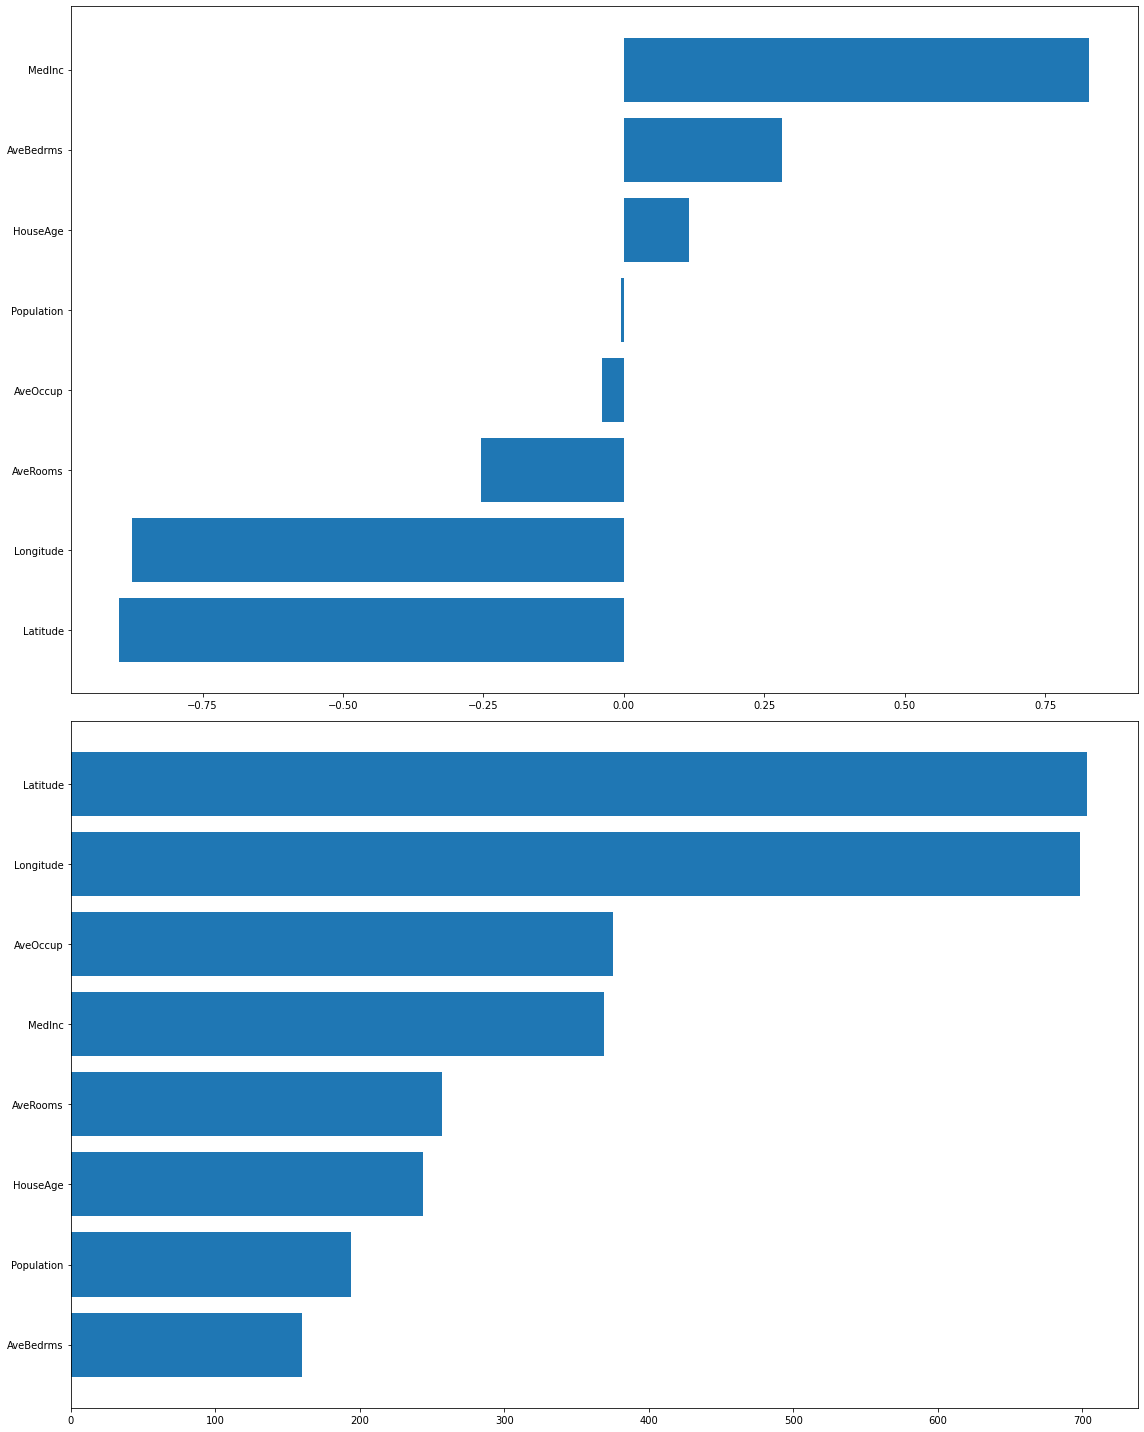

In [54]:
# プロット用に特徴量名格納
feature = np.array(data.feature_names)

# 線形回帰モデルの重み
linear_coef = linear.coef_

# lightgbmの特徴量重要度
lgb_importances = lgbmodel.feature_importances_

# それぞれをプロットする
# 重み/特徴量重要度をソート
linear_idx = np.argsort(linear_coef)
lgb_idx = np.argsort(lgb_importances)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 20))
ax = ax.flatten()

ax[0].barh(feature[linear_idx], linear_coef[linear_idx])
ax[1].barh(feature[lgb_idx], lgb_importances[lgb_idx])

plt.tight_layout()
plt.show()

結果として"Latitude", "Longitude", "MedInc"が2つのモデルで予測に大きく寄与していることがわかります．実際にこれら3つの特徴量で予測してみます．  

In [55]:
# 3つの特徴量データを抽出
X = df[["Latitude", "Longitude", "MedInc"]].values

# 訓練用データとテストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=6174)

# 訓練商データを更に訓練用と検証用に分ける
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

# 線形回帰ではスケーリングが必要
# GBDTでは大小関係のみ必要なため特に影響はない
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X, test_X = sc.transform(val_X), sc.transform(test_X)

linear = Ridge()
lgbmodel = lgb.LGBMRegressor(n_jobs=12, random_state=6174)

linear.fit(train_X, train_y)
lgbmodel.fit(train_X, train_y, eval_set=(val_X, val_y), verbose=-1)

linear_val_pred = linear.predict(val_X)
linear_test_pred = linear.predict(test_X)
linear_val_rmse = mse(val_y, linear_val_pred, squared=False)
linear_test_rmse = mse(test_y, linear_test_pred, squared=False)

lgb_val_pred = lgbmodel.predict(val_X)
lgb_test_pred = lgbmodel.predict(test_X)
lgb_val_rmse = mse(val_y, lgb_val_pred, squared=False)
lgb_test_rmse = mse(test_y, lgb_test_pred, squared=False)

print(f"Linear Model(Ridge) val score: {linear_val_rmse:.4f} test_score: {linear_test_rmse:.4f}")
print(f"LGB Model val score: {lgb_val_rmse:.4f} test score: {lgb_test_rmse:.4f}")

Linear Model(Ridge) val score: 0.7796 test_score: 0.7579
LGB Model val score: 0.5009 test score: 0.5034


今回のデータは元々特徴量の数が少ないこともあり，すべての手法でさほど有効ではありませんでしたが，データ内の特徴量に予測に関係ないようなものがある場合には特徴量抽出は有効です．  

## スパースモデリング  
埋め込み法では線形回帰とlightgbmを用いて，各特徴量の重要度を数値の大きさで表すことができましたが，数値の大きさではなく単純にどの特徴量が有用で，どれが不要なのかを表す方法があります．最も簡単な方法としてLasso回帰を用いることができます．Lasso回帰では線形回帰モデルの正則化項をL1ノルムにしたものですが，これを用いると使用しない特徴量の重みはすべて0になります．実際に見てみましょう．  

In [63]:
X = data["data"]

# 訓練用データとテストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=6174)

# 訓練商データを更に訓練用と検証用に分ける
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=6174)

# 線形回帰ではスケーリングが必要
# GBDTでは大小関係のみ必要なため特に影響はない
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X, test_X = sc.transform(val_X), sc.transform(test_X)

linear = Lasso(alpha=0.1)

linear.fit(train_X, train_y)

val_pred = linear.predict(val_X)
test_pred = linear.predict(test_X)
val_rmse = mse(val_y, val_pred, squared=False)
test_rmse = mse(test_y, test_pred, squared=False)

print(f"Linear Model(Ridge) val score: {val_rmse:.4f} test_score: {test_rmse:.4f}")
print(linear.coef_)

Linear Model(Ridge) val score: 0.8460 test_score: 0.8282
[ 0.70510033  0.10739984 -0.         -0.          0.         -0.
 -0.00612315 -0.        ]


デフォルトの設定ではすべて0になっていたため，正則化項の係数を0.1としてみました．その結果，3つの特徴量以外の重みは0になっていることがわかります．このように利用する特徴量を選択することも可能です．  